In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


CIFAR10 DATASET 로드

In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


train_x를 -1과 1사이의 값으로 정규화

In [4]:
train_x = (train_x-127.5)/127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [4]:
train_x = train_x.astype('float32')
train_x.shape

(50000, 32, 32, 3)

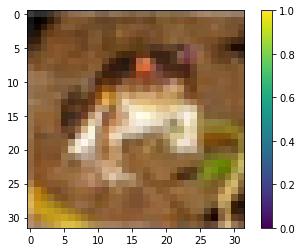

In [6]:
plt.imshow((train_x[0] + 1) / 2.0)
plt.colorbar()
plt.show()

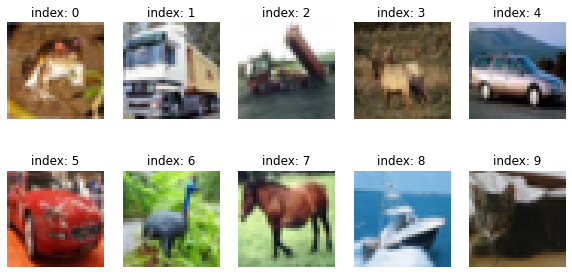

In [7]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_x[i]+ 1) / 2.0)
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

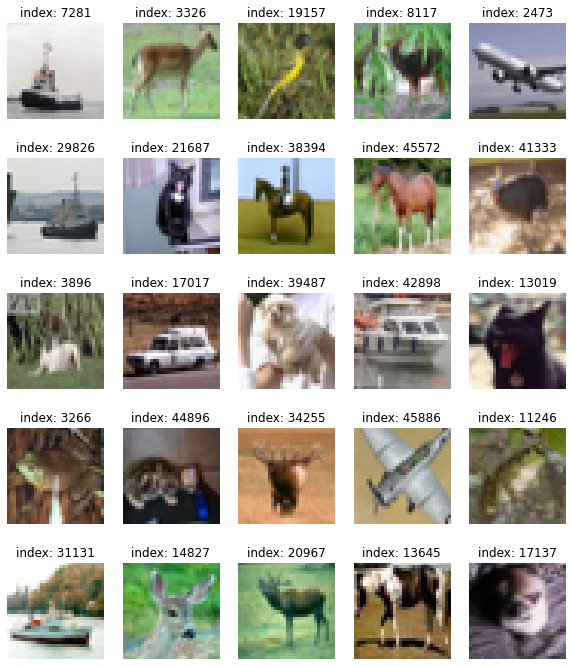

In [8]:
plt.figure(figsize=(10, 12))

for i in range(25):
    # [[YOUR CODE]]
    plt.subplot(5, 5, i+1)
    a = np.random.randint(1,50000)
    plt.imshow((train_x[a]+ 1) / 2.0)
    plt.title(f'index: {a}')
    plt.axis('off')
plt.show()

In [2]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
import tensorflow as tf
from tensorflow.keras import layers

def make_generator_model():
    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    # units은 8x8x256, 편향은 사용하지 않음, 입력 값의 크기는 100차원 벡터
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    

    # Third: Conv2DTranspose layer
    # 커널 크기는 5, stride는 1, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    # 커널 크기는 5, stride는 2, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
   
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))


    return model


In [7]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [8]:
noise = tf.random.normal([1, 100])

In [9]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

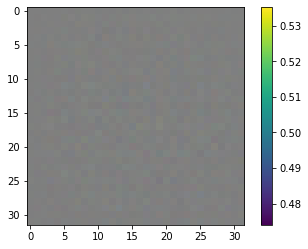

In [15]:
normalized_image = (generated_image[0] + 1) / 2.0
plt.imshow(normalized_image)
plt.colorbar()
plt.show()

In [10]:
def make_discriminator_model():
    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    # 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 이미지
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(32, 32, 3)))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    # 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())
    # Dropout은 0.3을 사용
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [11]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [12]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00300763]], dtype=float32)>

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss
    return total_loss


In [16]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [18]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [19]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)  # (5) Continued - 판별된 가짜 이미지

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)  #(6) Continued - real_output과 fake_output을 이용하여 discriminator_loss 계산

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)  #(8) Continued - discriminator의 gradient 계산

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))  #(9) Continued - optimizer를 이용한 모델 학습

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [20]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)
    predictions = (predictions + 1) / 2.0

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [21]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [22]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [34]:
save_every = 5
EPOCHS = 300

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

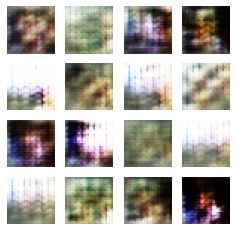

Epoch 17 | iter 51
Time for epoch 17 : 4 sec


KeyboardInterrupt: 

In [31]:
%%time
# [[YOUR CODE]]
train(train_dataset, EPOCHS, save_every)
# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [32]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1495254 Sep 20 04:28 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


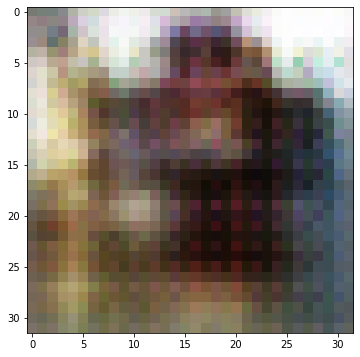

In [33]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

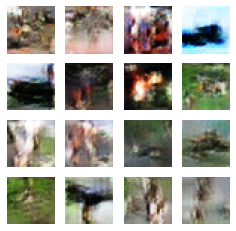

Time for training : 4784 sec


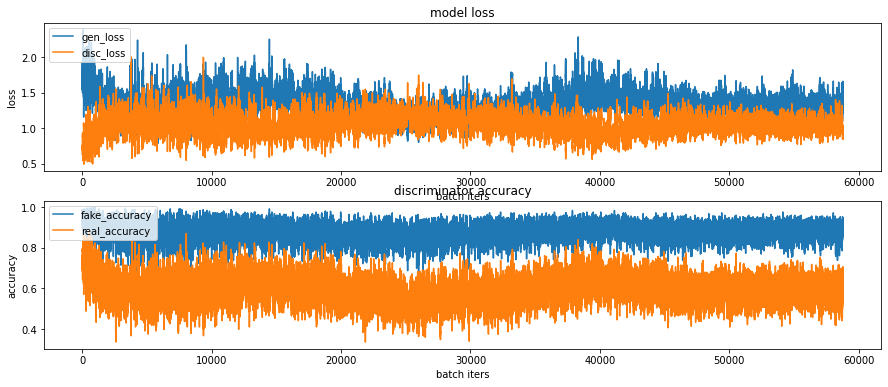

CPU times: user 1h 22min 28s, sys: 6min 27s, total: 1h 28min 55s
Wall time: 1h 19min 47s


In [35]:
%%time
# [[YOUR CODE]]
train(train_dataset, EPOCHS, save_every)

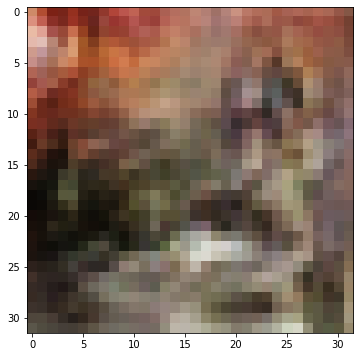

In [36]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

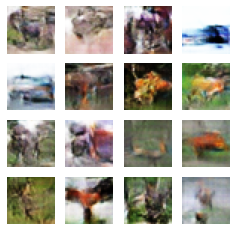

Time for training : 4798 sec


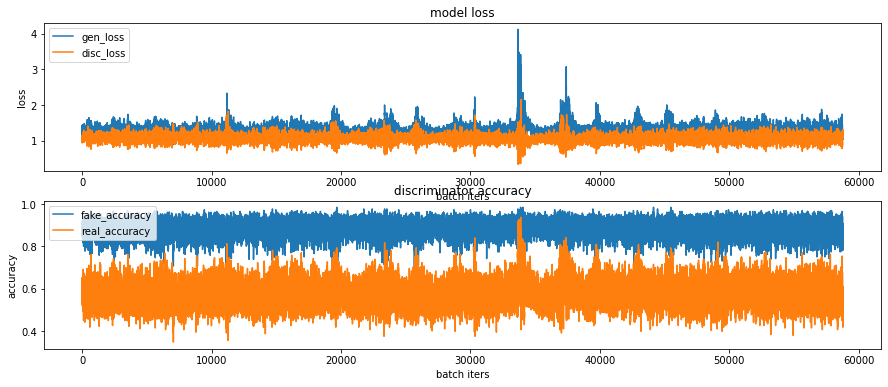

In [38]:
save_every = 5
EPOCHS = 300

# [[YOUR CODE]]
train(train_dataset, EPOCHS, save_every)

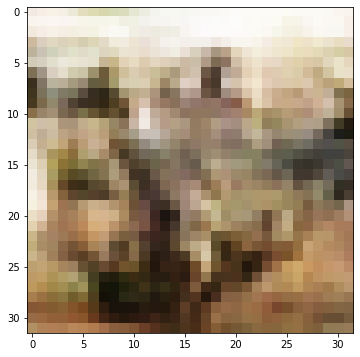

In [39]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

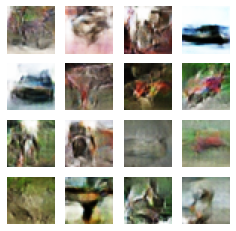

Time for training : 4877 sec


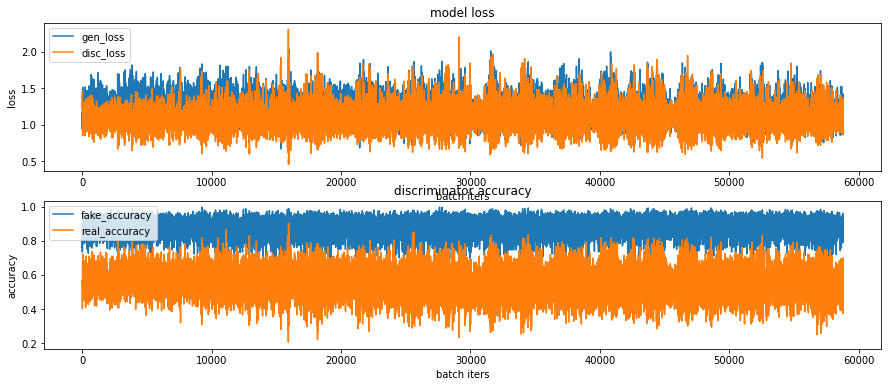

In [40]:
save_every = 5
EPOCHS = 300

# [[YOUR CODE]]
train(train_dataset, EPOCHS, save_every)

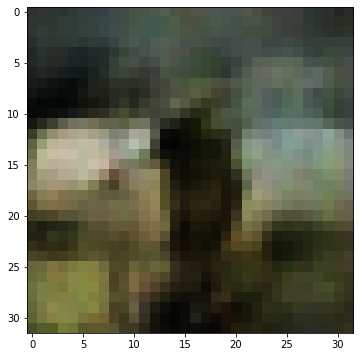

In [41]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

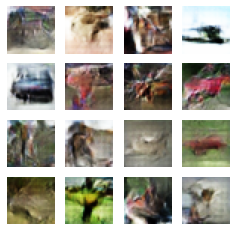

Time for training : 4862 sec


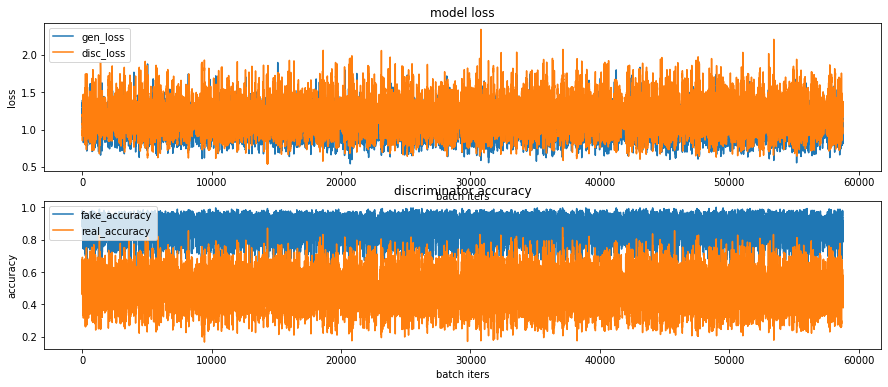

In [43]:
save_every = 5
EPOCHS = 300

# [[YOUR CODE]]
train(train_dataset, EPOCHS, save_every)

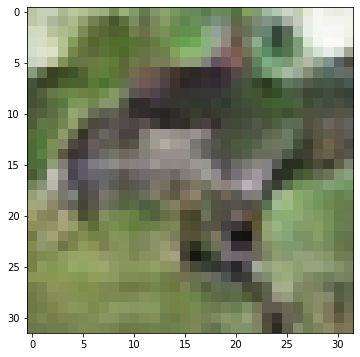

In [44]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

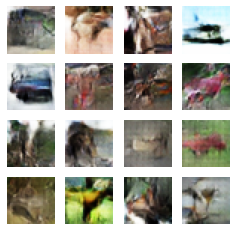

Time for training : 4880 sec


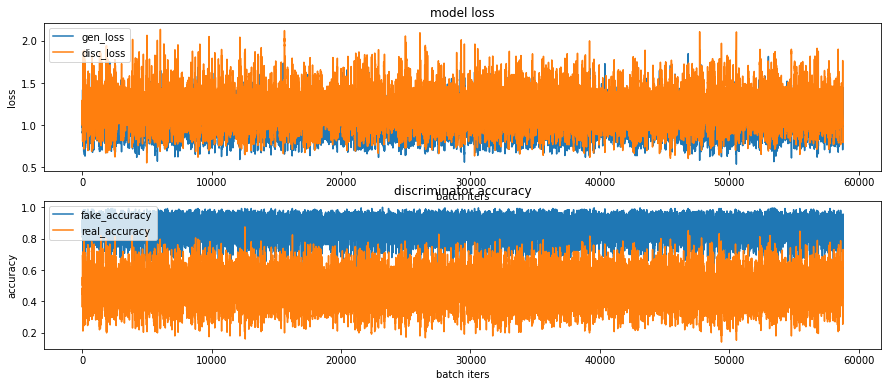

In [45]:
save_every = 5
EPOCHS = 300

# [[YOUR CODE]]
train(train_dataset, EPOCHS, save_every)

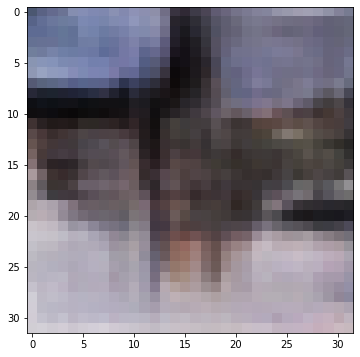

In [26]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

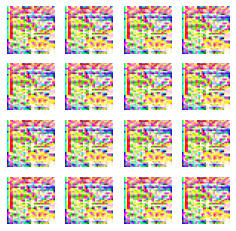

Epoch 1 | iter 1
Time for epoch 1 : 1 sec


KeyboardInterrupt: 

In [28]:
save_every = 5
EPOCHS = 300

# [[YOUR CODE]]
train(train_dataset, EPOCHS, save_every)

# 회고

- 처음 300 에폭까지 지속적으로 생성된 이미지의 quality가 높아져 추가적인 학습을 시키는 경우 더 발전을 이룰것으로 생각되었다. CIFAR 10의 데이터셋의 화질이 안 좋아서 그런지 생성되는 데이터 또한 확실하게 식별할 수 있는 데이터가 아닌 무언가 사물은 있지만 뭐지 이 정도의 데이터만 얻을 수 있었다. 그래도 학습을 계속 시키다 보니 조금씩 발전하는 경향은 볼 수 있었다.

- 마지막에 생성된 이미지의 경우 overfitting에 의해 나오는 현상으로 판단된다.(2000에폭 정도 돌림)

# 문제점

### 1. CIFAR10 DATASET의 한계

- CIFAR 10 DATASET은 32x32의 사진 60000장으로 이루어져 있다. GAN으로 Generate 하지 않은 원본 사진 또한 육안으로 확인시 구분이 어려운 사진들이 있다. 


### 2. DCGAN의 한계

- CIFAR 10은 10개의 CLASS 로 이루어져있다. 10개의 CLASS를 Generate model에 학습을 시키다 보면 Mode Collapse 가 일어날 수 있다. Mode Collapse란 10개의 CLASS를 모두 골고루 생성해내는 것이 아니라 생성하기 쉬운 몇개의 Class만을 Generate 시킨다.


# 해결방안

### 1. 모델의 깊이 추가
- Generate, Discriminate 모델의 깊이를 증가 시켜 복잡성을 늘려준다. MNIST 패션 데이터의 경우 실습시 흑백의 단순한 이미지다 보니 생성되는 데이터 또한 상당히 괜찮았으나 CIFAR10은 Color 이미지 이다 보니 채널이 3배 증가하여 보다 복잡한 구조를 가지고 있어야 모델의 성능이 좋아질 것으로 판단된다.

- 뒤의 파일에서 추가 작업을 시도하였으나. 깊이를 추가하는 것은 300 에폭을 돌렸을 때 성능에 기여하지 않았다. 오히려 연산 속도가 저하되어 훨씬 더 많은 시간만 소요 되었다. 추가적으로 학습시키면 결과가 어떻게 될지는 모르겠으나 일단 시간 대비 너무 효율이 좋지 않았다.

### 2. TRANFER LEARNING
- https://paperswithcode.com/sota/image-generation-on-cifar-10
- 해당 사이트에서 제공되는 CODE들을 보게 되면 기존의 DCGAN의 성능을 한참 웃도는 모델들이 많이 공개 되었다. 따라서 Pretrained Model을 사용하게 된다면 좋은 결과를 낼 것으로 판단된다.